# VF2 vs VF2++: Comparative analysis of performance 

Currently in NetworkX we have two isomorphism algorithms implemented: VF2 and VF2++.

**TODO:** Should I add an explanation of vf2 here? or maybe link to the isomorphism notebook 

**What's new on VF2++?** (Explaind more)
   - Node ordering 
   - Simple feasibility checks
   
Let's see an example of how to use VF2 and VF2++ to test for isomorphism with NetworkX.

In [2]:
import networkx as nx

G = nx.bull_graph()

print("VF2:  ", nx.is_isomorphic(G, G)) #VF2

print("VF2++: ",nx.vf2pp_is_isomorphic(G,G)) #VF2++

VF2:   True
VF2++:  True


## Benchmarking: General approach
To compare the performance of both algorithms we will run the algorithms over many different types of graphs and digraphs. The analysis will be divided as follows:
- Graphs (with and without labels)
    - Dense 
    - Sparce 
    - Densification of graphs: From sparce to dense
    - Connected vs unconnected 
- Digraphs (with and without labels)
    - Dense 
    - Sparce 
    - From sparce to dense

To measure execution time we can use the function *timeit(setup, stmt, number )*. Where *stmt* is the code that we want to time, *setup* is the code needed to run stmt but that we don't want to time and *number* is how many times stmt is run. 

Let's see an example:

In [3]:
import timeit

sleep_time = timeit.timeit(setup = "import time", #Setup code
              stmt = "time.sleep(2)", #Code to be timed  
              number = 1) #Number of times my code is going to be executed 

print("I was asleep for " + str(sleep_time) + " seconds")

I was asleep for 2.000795561999894 seconds


Given that the state of the CPU can change the execution time of our code it's important to repeat our measurements many times and the consider some way to summarize our data. We can use the median. To achive this we will use *repeat(setup, stmt, timer, number, repeat)*. 
Let's measure how much time it takes to create a balanced tree with networkX. We will repeat it 100 times and then take the median of all measumerements.

In [4]:
import numpy as np
import time
np.median(timeit.repeat(setup = "import networkx as nx", #Setup not included into
              stmt = "G = nx.balanced_tree(10, 2)", #Code to be measured 
              timer = time.process_time, #Only measure time used by the process running this code
              number = 1, 
              repeat = 100)) #repetitions

0.0002152914999999922

For more information about timeit: <https://docs.python.org/3/library/timeit.html>

**Disclairmer:** The graphs used to benchmark the algorithms are going to be small because the execution time grows exponentially and otherwise the examples are going to take too much time to run. Also to do a more exhautive benchmarking we need to repeat all the measurements many times and use bigger graphs. 

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [5]:
def density(n, m):
    return m/(n*(n-1)/2)

## Graphs ( Without labels) 

### Complete Graphs 
We can compare both algorithms on complete graphs as a way to see how these algorithms behave on dense graphs.
Let's measure how much it takes to both algorithms to run in complete graphs as we increase the number of nodes in the graphs. For these graphs we are interested in identify positive instances,on other words, we want to test graphs that are isomorphic. 

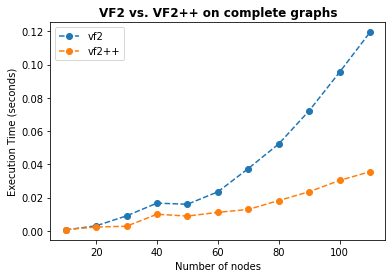

In [12]:
vf2_all_times = []
vf2pp_all_times = []

for i in range(10, 120, 10):
    #time vf2 
    vf2_time = np.median(timeit.repeat(setup = "import networkx as nx;G = nx.complete_graph(" + str(i) +")",
                             stmt= "nx.is_isomorphic(G,G)", timer = time.process_time,
                                       number=1, repeat=100))
    vf2_all_times.append(vf2_time)
    
    #time vf2++
    vf2pp_time = np.median(timeit.repeat(setup = "import networkx as nx;G = nx.complete_graph(" + str(i) +")",
                               stmt= "nx.vf2pp_is_isomorphic(G,G)", timer = time.process_time,
                                         number=1, repeat=100))
    vf2pp_all_times.append(vf2pp_time)

#Plot results 
fig, ax = plt.subplots()

x = list(range(10, 120, 10)) #x labels

vf2_line, = ax.plot(x,  vf2_all_times, label = "vf2", linestyle='--', marker='o')
vf2pp_line, = ax.plot(x,vf2pp_all_times,label = "vf2++", linestyle='--', marker='o')

plt.title("VF2 vs. VF2++ on complete graphs", fontweight = "bold")
plt.ylabel("Execution Time (seconds)")
plt.xlabel("Number of nodes")  
ax.legend(handles=[vf2_line, vf2pp_line])

plt.show()

As expected VF2++ performs better than VF2 as we increase the number of nodes. Also, we can see that the curve of VF2 grows significantly faster compared to the curve of VF2++. Also from this we can't affirm that VF2++ has a linear behavior on complete graphs. 

### Random Regular Graphs

A random $d$-regular graph is a graph ramdomly selected from all $d$-regular graphs of $n$ vertices, where $3\leq d < n$ and $nr$ is even. A $d$-regular graph is a graph where each node have exactly $d$ neighbours. That means that all nodes have the same degree. These graphs are interesting for our experiments because as we increase $d$ we will have graphs that gets more dense. This is an easy way to see how the algorithms perform as we make graphs more dense. In our example we take a graph of 15 nodes and we will increase $d$. Again We will focus on positive instances. 

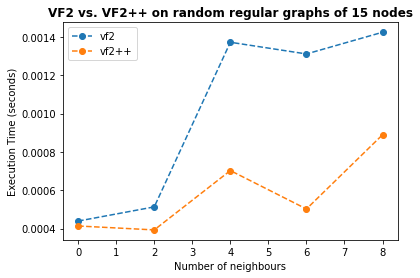

In [14]:
vf2_all_times = []
vf2pp_all_times = []


for i in range(0, 10,  2):
    #vf2 
    vf2_time = np.median(timeit.repeat(setup = "import networkx as nx;G = nx.random_regular_graph("+ str(i) +",15 , seed= 104)",
                             stmt= "nx.is_isomorphic(G,G)",timer = time.process_time,
                                       number=1, repeat = 100))
    vf2_all_times.append(vf2_time)
    
    #vf2++
    vf2pp_time = np.median(timeit.repeat(setup = "import networkx as nx;G = nx.random_regular_graph("+ str(i) +",15 , seed= 104)",
                             stmt= "nx.vf2pp_is_isomorphic(G,G)",timer = time.process_time,
                                       number=1, repeat = 100))
    vf2pp_all_times.append(vf2pp_time)

#Plot results 
fig, ax = plt.subplots()

x = list(range(0, 10,  2))

vf2_line, = ax.plot(x, vf2_all_times, label = "vf2", linestyle='--', marker='o')
vf2pp_line, = ax.plot(x, vf2pp_all_times,label = "vf2++", linestyle='--', marker='o')

plt.title("VF2 vs. VF2++ on random regular graphs of 15 nodes", fontweight = "bold")
plt.ylabel("Execution Time (seconds)")
plt.xlabel("Number of neighbours")
ax.legend(handles=[vf2_line, vf2pp_line])

plt.show()

Once again VF2++ is significantly faster than VF2. It's interesting to analyze that VF2++ execution time doesn't always grow as graphs get denser. This could be because the node ordering makes that for some graphs unfruitful branches are explored first. 

## Erdos-Renyi Random graphs
A random erdos-renyi graph $G_{n, p}$ is a graph of $n$ nodes where all possible edges are added with probability $p$. With these graphs we can easily create graphs with similar density for multiple values of $n$. We will use these graphs to see how the algorithms behave on graphs with the same density as we increase the number of nodes in positive instances.
Let's do this experiment for different values of $p$:

### TODO: case p = 0.8 and put all plots together

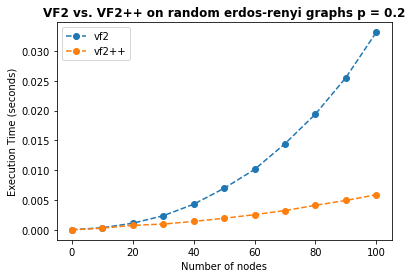

In [16]:
# p = 0.2

vf2_all_times = []
vf2pp_all_times = []

for i in range(0, 101, 10):
    #vf2 
    vf2_time = np.median(timeit.repeat(setup = "import networkx as nx;G = nx.erdos_renyi_graph("+ str(i) +", 0.2 , seed= 200)",
                             stmt= "nx.is_isomorphic(G,G)", timer = time.process_time,
                             number=1, repeat = 100))
    vf2_all_times.append(vf2_time)
    
    #vf2++
    vf2pp_time = np.median(timeit.repeat(setup = "import networkx as nx;G = nx.erdos_renyi_graph("+ str(i) +", 0.2 , seed= 200)",
                             stmt= "nx.vf2pp_is_isomorphic(G,G)", timer = time.process_time,
                             number=1, repeat = 100))
    vf2pp_all_times.append(vf2pp_time)

#Plot results 
fig, ax = plt.subplots()

x = list(range(0, 101, 10))

vf2_line, = ax.plot(x,  vf2_all_times, label = "vf2", linestyle='--', marker='o')
vf2pp_line, = ax.plot(x, vf2pp_all_times,label = "vf2++", linestyle='--', marker='o')



plt.title("VF2 vs. VF2++ on random erdos-renyi graphs p = 0.2", fontweight = "bold")
plt.ylabel("Execution Time (seconds)")
plt.xlabel("Number of nodes")
ax.legend(handles=[vf2_line, vf2pp_line])

plt.show()

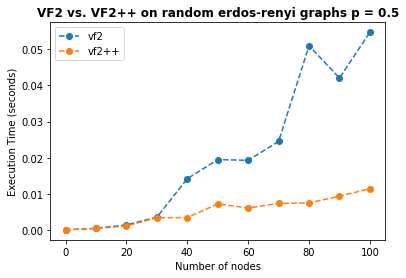

In [19]:
# p = 0.5

vf2_all_times = []
vf2pp_all_times = []
 
for i in range(0, 101, 10):
    #vf2 
    vf2_time = np.median(timeit.repeat(setup = "import networkx as nx;G = nx.erdos_renyi_graph("+ str(i) +", 0.5 , seed= 200)",
                             stmt= "nx.is_isomorphic(G,G)", timer = time.process_time,
                             number=1, repeat = 100))
    vf2_all_times.append(vf2_time)
    
    #vf2++
    vf2pp_time = np.median(timeit.repeat(setup = "import networkx as nx;G = nx.erdos_renyi_graph("+ str(i) +", 0.5 , seed= 200)",
                             stmt= "nx.vf2pp_is_isomorphic(G,G)", timer = time.process_time,
                             number=1, repeat = 100))
    vf2pp_all_times.append(vf2pp_time)

#Plot results 
fig, ax = plt.subplots()


x = list(range(0, 101, 10))

vf2_line, = ax.plot(x,vf2_all_times, label = "vf2", linestyle='--', marker='o')
vf2pp_line, = ax.plot(x, vf2pp_all_times,label = "vf2++", linestyle='--', marker='o')



plt.title("VF2 vs. VF2++ on random erdos-renyi graphs p = 0.5", fontweight = "bold")
plt.ylabel("Execution Time (seconds)")
plt.xlabel("Number of nodes")
ax.legend(handles=[vf2_line, vf2pp_line])


plt.show()

In [25]:
#TAKES FOREVER 

# p = 0.8 

vf2_all_times = []
vf2pp_all_times = []
 


for i in range(0, 101, 10):
    #vf2 
    vf2_time = np.median(timeit.repeat(setup = "import networkx as nx;G = nx.erdos_renyi_graph("+ str(i) +", 0.8 , seed= 200)",
                             stmt= "nx.is_isomorphic(G,G)", timer = time.process_time,
                             number=1, repeat = 100))
    vf2_all_times.append(vf2_time)
    
    #vf2++
    vf2pp_time = np.median(timeit.repeat(setup = "import networkx as nx;G = nx.erdos_renyi_graph("+ str(i) +", 0.8 , seed= 200)",
                             stmt= "nx.vf2pp_is_isomorphic(G,G)", timer = time.process_time,
                             number=1, repeat = 100))
    vf2pp_all_times.append(vf2pp_time)

#Plot results 
fig, ax = plt.subplots()

vf2_line, = ax.plot(vf2_all_times, label = "vf2", linestyle='--', marker='o')
vf2pp_line, = ax.plot(vf2pp_all_times,label = "vf2++", linestyle='--', marker='o')

x = list(range(0, 101, 10))

plt.title("VF2 vs. VF2++ on random erdos-renyi graphs p = 0.8", fontweight = "bold")
plt.ylabel("Execution Time (seconds)")
plt.xlabel("Number of nodes")
ax.legend(handles=[vf2_line, vf2pp_line])
 

plt.show()

KeyboardInterrupt: 

## Create graphs from a degree secuence 

To test on negative instances, in other words, graphs that are not isomorphic we need to create graphs with the same degree secuence. For that we can use *nx.configuration_model(degree_sequence)* that creates a random graph with the given degree secuence. The degree secuence must have a even sum. Let's see in an example how can we experiment with this:

In [22]:
#Example
import random
random.seed(11) #Set a random seed 
d = random.choices(list(range(0, 5)), k =11) #Create a list with 11 random numbers in [0, 5]

print( "is even? ", np.sum(d)%2 == 0)

#Create 2 diffenrent random graphs with the same degree secuence 
g1 = nx.Graph(nx.configuration_model(d, seed = 10))
g1.remove_edges_from(nx.selfloop_edges(g1))

g2 = nx.Graph(nx.configuration_model(d, seed = 11))
g2.remove_edges_from(nx.selfloop_edges(g2))

print(nx.Graph(g1))
print("Are isomorphic? " , nx.is_isomorphic(g1, g2))

is even?  True
Graph with 11 nodes and 9 edges
Are isomorphic?  False


Experiment : Same degree sequence - not isomorphic

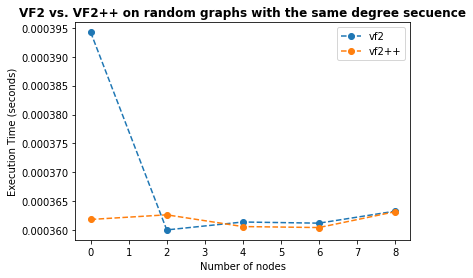

In [24]:

#TODO get a secuences of seeds that generate valid degree secuences 

vf2_all_times = []
vf2pp_all_times = []

for i in range(0, 10,  2):
    #vf2 
    vf2_time = np.median(timeit.repeat(
        setup = "import networkx as nx;import random;random.seed(11);d = random.choices(list(range(0, 5)), k =10);g1 = nx.configuration_model(d, seed = 10);g2 = nx.configuration_model(d, seed = 11)",
                             stmt= "nx.is_isomorphic(g1,g2)",timer = time.process_time,
                                       number=1, repeat = 100))
    vf2_all_times.append(vf2_time)
    
    #vf2++
    vf2pp_time = np.median(timeit.repeat(
        setup = "import networkx as nx;import random;random.seed(11);d = random.choices(list(range(0, 5)), k =10);g1 = nx.configuration_model(d, seed = 10);g2 = nx.configuration_model(d, seed = 11)",
                             stmt= "nx.is_isomorphic(g1,g2)",timer = time.process_time,
                                       number=1, repeat = 100))
    vf2pp_all_times.append(vf2pp_time)

#Plot results 
fig, ax = plt.subplots()

x = list(range(0, 10,  2))

vf2_line, = ax.plot(x,vf2_all_times, label = "vf2", linestyle='--', marker='o')
vf2pp_line, = ax.plot(x,vf2pp_all_times,label = "vf2++", linestyle='--', marker='o')

plt.title("VF2 vs. VF2++ on random graphs with the same degree secuence", fontweight = "bold")
plt.ylabel("Execution Time (seconds)")
plt.xlabel("Number of nodes")
ax.legend(handles=[vf2_line, vf2pp_line]) 

plt.show()

## - With labels (node vs edges)

- Same graph with same attributes and same graphs with different attr

# Digraphs

Complete digraphs

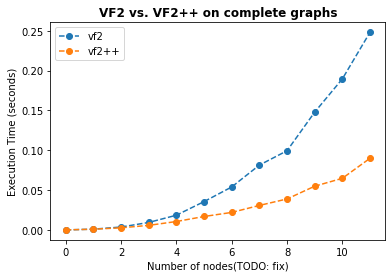

In [72]:
vf2_all_times = []
vf2pp_all_times = []

for i in range(1, 120, 10):
    #time vf2 
    vf2_time = np.median(timeit.repeat(setup = "import networkx as nx;G = nx.complete_graph(" + str(i) +", nx.DiGraph())",
                             stmt= "nx.is_isomorphic(G,G)", timer = time.process_time,
                                       number=1, repeat=100))
    vf2_all_times.append(vf2_time)
    
    #time vf2++
    vf2pp_time = np.median(timeit.repeat(setup = "import networkx as nx;G = nx.complete_graph(" + str(i) +", nx.DiGraph())",
                               stmt= "nx.vf2pp_is_isomorphic(G,G)", timer = time.process_time,
                                         number=1, repeat=100))
    vf2pp_all_times.append(vf2pp_time)

#Plot results 
fig, ax = plt.subplots()

vf2_line, = ax.plot(vf2_all_times, label = "vf2", linestyle='--', marker='o')
vf2pp_line, = ax.plot(vf2pp_all_times,label = "vf2++", linestyle='--', marker='o')

x = list(range(0, 120, 10))

plt.title("VF2 vs. VF2++ on complete graphs", fontweight = "bold")
plt.ylabel("Execution Time (seconds)")
plt.xlabel("Number of nodes(TODO: fix)")
ax.legend(handles=[vf2_line, vf2pp_line])
#ax.set_xticklabels(x) TODO: fix x labels 

plt.show()

# Final Conclusions

# References
- TODO: Add Papers 